In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.animation
import numpy as np
import pandas as pd
import seaborn as sns
import math
from IPython.display import HTML
from scipy import stats
from scipy.signal import butter, lfilter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [28]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [29]:
from PIL import Image, ImageOps
import glob

## Reading the data

In [30]:
data = pd.read_csv('reference_data.csv')
data.head()

Unnamed: 0  SessionId  PatientId  CardiacLim  PulmonaryLim  \
0           0        7.0        7.0           1             0   
1          31        8.0        8.0           1             0   
2          58        9.0        9.0           0             0   
3          95       10.0       10.0           0             0   
4         132       11.0       11.0           0             0   

   MuscleSkeletalLim           HR           VO2           VCO2           VE  \
0                  0   7_0_HR.png   7_0_VO2.png   7_0_VCO2.png   7_0_VE.png   
1                  0   8_0_HR.png   8_0_VO2.png   8_0_VCO2.png   8_0_VE.png   
2                  0   9_0_HR.png   9_0_VO2.png   9_0_VCO2.png   9_0_VE.png   
3                  0  10_0_HR.png  10_0_VO2.png  10_0_VCO2.png  10_0_VE.png   
4                  0  11_0_HR.png  11_0_VO2.png  11_0_VCO2.png  11_0_VE.png   

            RER           RR           O2  
0   7_0_RER.png   7_0_RR.png   7_0_O2.png  
1   8_0_RER.png   8_0_RR.png   8_0_O2.png  
2   9_0_RER.png   9_0_RR.png   9_0_O2.png  
3  10_0_RER.png  10_0_RR.png  10_0_O2.png  
4  11_0_RER.png  11_0_RR.png  11_0_O2.png

In [31]:
s1 = np.random.choice(range(data.shape[0]), int(data.shape[0]*.75), replace=False)
s2 = list(set(range(data.shape[0])) - set(s1))

In [32]:
def load_img(img_name, rescale=False):
    if rescale is False:
        image = Image.open('./data/images/'+img_name)
    else:
        image = Image.open('./data/images/'+img_name).resize([64,64])
    image = ImageOps.grayscale(image)
    result = np.array(image).astype(np.float32) / 255.0
    width, height = image.size
    return result, width, height

In [33]:
result = load_img(data.iloc[0].HR, True)
result2 = load_img(data.iloc[0].VO2, True)
result3 = load_img(data.iloc[0].VCO2, True)
result_appended = np.array([[result[0],result2[0],result3[0]]])
#print(result_appended.shape)
result_appended=result_appended.reshape(-1, 64,64,3)
#print(result_appended.shape)
#result2[0].shape


In [34]:
res = np.swapaxes(result_appended,1,3)
res.shape

(1, 3, 64, 64)

In [35]:
result_appended.shape

(1, 64, 64, 3)

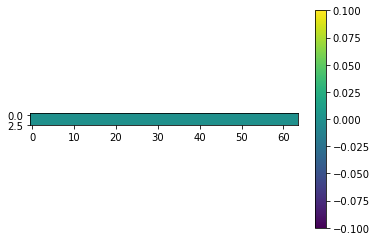

In [36]:
#plt.imshow(result_appended_ori[0,0,:,:])
plt.imshow(res[0,:,:,0])
plt.colorbar()

In [37]:
result_hr = load_img(data.iloc[1].HR, True)
result_vo2 = load_img(data.iloc[1].VO2, True)
result_vco2 = load_img(data.iloc[1].VCO2, True)
result_ve = load_img(data.iloc[1].VE, True)
result_rer = load_img(data.iloc[1].RER, True)
result_rr = load_img(data.iloc[1].RR, True)
result_o2 = load_img(data.iloc[1].O2, True)
result_appended2 = np.array([[result_hr[0],result_vo2[0],result_vco2[0], 
                              result_ve[0],result_rer[0],result_rr[0], result_o2[0]]])
print(result_appended2.shape)
result_appended2=result_appended.reshape(1, 64,64,3)
print(result_appended2.shape)

(1, 7, 64, 64)
(1, 64, 64, 3)


In [38]:
res = np.append(result_appended,result_appended2,axis=0)
res.shape

(2, 64, 64, 3)

In [39]:
data.columns

Index(['Unnamed: 0', 'SessionId', 'PatientId', 'CardiacLim', 'PulmonaryLim',
       'MuscleSkeletalLim', 'HR', 'VO2', 'VCO2', 'VE', 'RER', 'RR', 'O2'],
      dtype='object')

## Adding values

In [40]:
s1

array([ 18, 212, 223, 186,  38,  61, 181,  91, 208, 159, 112, 101, 173,
       174,  57, 167,  72, 126,  53,   8, 107,  36,  14, 164, 109, 129,
         9, 216,  15, 177, 196,  12,  47, 113, 100, 148, 199, 165, 219,
       180,  49,  67,  45,  19,  74,  66,  40,  97,  65,   7,  26,  71,
        77, 217,  17,  63, 128,  73,  83,  89,  35, 176, 153, 190, 197,
       149, 210, 201,  24,  93,  84,  79, 117, 184, 206,  76,  95, 102,
       118,  25,  86, 162,  13, 214, 108,   4, 209, 182,  32, 188, 144,
       130, 169,  55, 137, 140,  20, 222,  69,   5, 154, 133, 115, 178,
        50, 145,  75, 213, 147,   1, 104,  87, 203, 141,  31,  92, 119,
       172,  98, 131,  78,  44,  39, 139,  94, 124, 158, 120, 192, 146,
       185,  60, 132,  51, 183,  54,  90, 135,  48, 151, 207, 122,  37,
       224, 142, 179,  10, 220, 123,  27, 125,  59, 105, 200, 194, 111,
        11, 134,  62,  46,  28, 103, 166, 114, 136, 204, 175, 211])

In [41]:
train_x = np.empty((0,64,64,7))
for item in s1:
    result_hr = load_img(data.iloc[item].HR, True)
    result_vo2 = load_img(data.iloc[item].VO2, True)
    result_vco2 = load_img(data.iloc[item].VCO2, True)
    result_ve = load_img(data.iloc[item].VE, True)
    result_rer = load_img(data.iloc[item].RER, True)
    result_rr = load_img(data.iloc[item].RR, True)
    result_o2 = load_img(data.iloc[item].O2, True)
    result = np.array([[result_hr[0].T,result_vo2[0].T,result_vco2[0].T, 
                        result_ve[0].T,result_rer[0].T,result_rr[0].T, result_o2[0].T]])
    result = np.swapaxes(result,1,3)
    train_x = np.append(train_x, result,axis=0)

In [42]:
train_x.shape

(168, 64, 64, 7)

In [43]:
test_x = np.empty((0,64,64,7))
for item in s2:
    result_hr = load_img(data.iloc[item].HR, True)
    result_vo2 = load_img(data.iloc[item].VO2, True)
    result_vco2 = load_img(data.iloc[item].VCO2, True)
    result_ve = load_img(data.iloc[item].VE, True)
    result_rer = load_img(data.iloc[item].RER, True)
    result_rr = load_img(data.iloc[item].RR, True)
    result_o2 = load_img(data.iloc[item].O2, True)
    result = np.array([[result_hr[0].T,result_vo2[0].T,result_vco2[0].T, 
                        result_ve[0].T,result_rer[0].T,result_rr[0].T, result_o2[0].T]])
    result = np.swapaxes(result,1,3)
    test_x = np.append(test_x, result,axis=0)

In [44]:
test_x.shape

(57, 64, 64, 7)

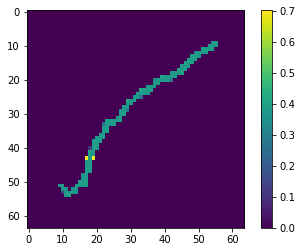

In [46]:
plt.imshow(train_x[0,:,:,0])
plt.colorbar()

In [52]:
train_y = data[['CardiacLim','PulmonaryLim','MuscleSkeletalLim']].values[s1]
test_y = data[['CardiacLim','PulmonaryLim','MuscleSkeletalLim']].values[s2]

## Doing 3 independent models, 1st for the cardiac

In [48]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [247]:
train_x_one = train_x[:,:,:,0]
test_x_one = test_x[:,:,:,0]
train_x_one = train_x_one.reshape(-1, 64, 64, 1)
test_x_one = test_x_one.reshape(-1, 64, 64, 1)

In [248]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
model.fit(train_x_one, y_cardiac, batch_size=5, epochs=15)

Epoch 1/15
34/34 [==============================] - 0s 9ms/step - loss: 0.6180 - acc: 0.6786
Epoch 2/15
34/34 [==============================] - 0s 9ms/step - loss: 0.5561 - acc: 0.7083
Epoch 3/15
34/34 [==============================] - 0s 8ms/step - loss: 0.5148 - acc: 0.7083
Epoch 4/15
34/34 [==============================] - 0s 8ms/step - loss: 0.5558 - acc: 0.6964
Epoch 5/15
34/34 [==============================] - 0s 8ms/step - loss: 0.4666 - acc: 0.7619
Epoch 6/15
34/34 [==============================] - 0s 8ms/step - loss: 0.5027 - acc: 0.7143
Epoch 7/15
34/34 [==============================] - 0s 8ms/step - loss: 0.4753 - acc: 0.7976
Epoch 8/15
34/34 [==============================] - 0s 8ms/step - loss: 0.4738 - acc: 0.7857
Epoch 9/15
34/34 [==============================] - 0s 8ms/step - loss: 1.0079 - acc: 0.8095
Epoch 10/15
34/34 [==============================] - 0s 8ms/step - loss: 0.6154 - acc: 0.7798
Epoch 11/15
34/34 [==============================] - 0s 8ms/step - lo

In [219]:
y_cardiac =data[['CardiacLim']].values[s1]
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
model.fit(train_x_one, y_cardiac, batch_size=5, epochs=10)

Epoch 1/10
34/34 [==============================] - 0s 4ms/step - loss: 4.7752 - acc: 0.6905
Epoch 2/10
34/34 [==============================] - 0s 3ms/step - loss: 4.7744 - acc: 0.6905
Epoch 3/10
34/34 [==============================] - 0s 3ms/step - loss: 4.7744 - acc: 0.6905
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 4.7744 - acc: 0.6905
Epoch 5/10
34/34 [==============================] - 0s 3ms/step - loss: 3.2661 - acc: 0.7083
Epoch 6/10
34/34 [==============================] - 0s 3ms/step - loss: 2.5946 - acc: 0.6488
Epoch 7/10
34/34 [==============================] - 0s 3ms/step - loss: 7.6937 - acc: 0.4345
Epoch 8/10
34/34 [==============================] - 0s 3ms/step - loss: 10.5292 - acc: 0.3095
Epoch 9/10
34/34 [==============================] - 0s 3ms/step - loss: 10.5292 - acc: 0.3095
Epoch 10/10
34/34 [==============================] - 0s 3ms/step - loss: 10.5292 - acc: 0.3095


In [249]:
test_loss, test_acc = model.evaluate(test_x_one, test_y, batch_size=5)

12/12 [==============================] - 0s 3ms/step - loss: 2.8661 - acc: 0.7953


In [250]:
model.predict(train_x_one)
score = tf.nn.softmax(model.predict(train_x_one))

In [251]:
tf.nn.sigmoid(model.predict(test_x_one))

<tf.Tensor: shape=(57, 1), dtype=float32, numpy=
array([[0.38956183],
       [0.5479959 ],
       [0.598995  ],
       [0.40280357],
       [0.44540337],
       [0.40744454],
       [0.3921313 ],
       [0.4165275 ],
       [0.4007819 ],
       [0.34953332],
       [0.428909  ],
       [0.46163458],
       [0.45252922],
       [0.48190865],
       [0.336941  ],
       [0.37695834],
       [0.407709  ],
       [0.5245657 ],
       [0.39933974],
       [0.5183859 ],
       [0.4730066 ],
       [0.43944156],
       [0.4370255 ],
       [0.5305908 ],
       [0.38949764],
       [0.44576684],
       [0.4284611 ],
       [0.44701558],
       [0.3644992 ],
       [0.4029695 ],
       [0.39836478],
       [0.414163  ],
       [0.36302984],
       [0.45921463],
       [0.4180318 ],
       [0.48966235],
       [0.41702774],
       [0.41268864],
       [0.41197783],
       [0.3732594 ],
       [0.3626413 ],
       [0.3596491 ],
       [0.46558812],
       [0.47563   ],
       [0.42021924],
      

In [254]:
def evaluate_model(y_values, x_values, model_result):
    tn, fp, fn, tp = confusion_matrix(y_values[:,0], np.round(tf.nn.sigmoid(model_result.predict(x_values))).flatten()).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    positive_predictive_value = tp / (tp+fp)
    print(f'Positive Predictive Value {positive_predictive_value}')
    print(f'specificity {specificity}')
    print(f'sensitivity {sensitivity}')
    print(f'confusion matrix')
    print(confusion_matrix(y_values[:,0], np.round(tf.nn.sigmoid(model_result.predict(x_values))).flatten()))
    pass

In [257]:
evaluate_model(test_y,test_x_one,model)

Positive Predictive Value 0.5
specificity 0.918918918918919
sensitivity 0.15
confusion matrix
[[34  3]
 [17  3]]


In [258]:
evaluate_model(train_y,train_x_one,model)

Positive Predictive Value 1.0
specificity 1.0
sensitivity 0.21153846153846154
confusion matrix
[[116   0]
 [ 41  11]]


## Adding multiple layers to the first model

In [276]:
train_x_two = train_x[:,:,:,0:4]
test_x_two = test_x[:,:,:,0:4]
#train_x_two = train_x_one.reshape(-1, 64, 64, 1)
#test_x_two = test_x_one.reshape(-1, 64, 64, 1)

In [277]:
train_x_two.shape

(168, 64, 64, 4)

In [280]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
model.fit(train_x_two, y_cardiac, batch_size=7, epochs=20)

Epoch 1/20
24/24 [==============================] - 0s 10ms/step - loss: 0.7903 - acc: 0.6786
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.5181 - acc: 0.6845
Epoch 3/20
24/24 [==============================] - 0s 10ms/step - loss: 0.4792 - acc: 0.7024
Epoch 4/20
24/24 [==============================] - 0s 10ms/step - loss: 0.4424 - acc: 0.7560
Epoch 5/20
24/24 [==============================] - 0s 9ms/step - loss: 0.4041 - acc: 0.7917
Epoch 6/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3744 - acc: 0.8214
Epoch 7/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3865 - acc: 0.7857
Epoch 8/20
24/24 [==============================] - 0s 9ms/step - loss: 0.4244 - acc: 0.8750
Epoch 9/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3160 - acc: 0.8929
Epoch 10/20
24/24 [==============================] - 0s 9ms/step - loss: 0.2975 - acc: 0.8690
Epoch 11/20
24/24 [==============================] - 0s 9ms/step -

In [281]:
test_loss, test_acc = model.evaluate(test_x_two, test_y, batch_size=5)

12/12 [==============================] - 0s 3ms/step - loss: 1.1039 - acc: 0.7602


In [284]:
evaluate_model(test_y,test_x_two,model)

Positive Predictive Value 0.6071428571428571
specificity 0.7027027027027027
sensitivity 0.85
confusion matrix
[[26 11]
 [ 3 17]]


In [285]:
evaluate_model(train_y,train_x_two,model)

Positive Predictive Value 0.7222222222222222
specificity 0.8275862068965517
sensitivity 1.0
confusion matrix
[[96 20]
 [ 0 52]]


In [290]:
tf.nn.sigmoid(model.predict(test_x_two)).numpy().flatten()

array([0.4575011 , 0.5389181 , 0.5759187 , 0.45322144, 0.66372585,
       0.6395423 , 0.41877395, 0.4594317 , 0.45776156, 0.3852632 ,
       0.5455725 , 0.60958403, 0.5857439 , 0.46148092, 0.33205587,
       0.38725817, 0.64357805, 0.6113527 , 0.7003854 , 0.7140657 ,
       0.46577573, 0.58895385, 0.5777448 , 0.7060578 , 0.36139897,
       0.50332046, 0.58284   , 0.48128185, 0.43203634, 0.4122795 ,
       0.4200255 , 0.3599704 , 0.3830358 , 0.361419  , 0.52265686,
       0.395113  , 0.41069776, 0.49886346, 0.4717308 , 0.35032153,
       0.35388684, 0.416738  , 0.63799727, 0.54663163, 0.62922883,
       0.4989144 , 0.49578595, 0.55028605, 0.34379917, 0.4658691 ,
       0.6233893 , 0.66619694, 0.65165305, 0.5768809 , 0.68225557,
       0.51511264, 0.59775424], dtype=float32)

In [299]:
auc = roc_auc_score(test_y[:,0],  tf.nn.sigmoid(model.predict(test_x_two)).numpy().flatten(), multi_class='ovr')
fpr, tpr, _ = roc_curve(test_y[:,0],  tf.nn.sigmoid(model.predict(test_x_two)).numpy().flatten())
plt.plot(fpr, tpr, marker='.', label='Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title("ROC curve with AUC={:.2f}".format(auc))
# show the plot
plt.show()

In [296]:
test_x_two.shape

(57, 64, 64, 4)

### Conclussion:
The more signals we add, the better the performance of the algorithm but it also needs more training. At four chanels, the accuracy is over 0.76 and AUC on the **test dataset** is 0.84 which is way better than the random forest and the logistic regression

## Model with the 7 chanels

In [301]:
train_x_full = train_x[:,:,:,:]
test_x_full = test_x[:,:,:,:]

In [308]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
model.fit(train_x_full, y_cardiac, batch_size=5, epochs=25)

Epoch 1/25
34/34 [==============================] - 0s 9ms/step - loss: 3.7242 - acc: 0.5536
Epoch 2/25
34/34 [==============================] - 0s 9ms/step - loss: 0.5298 - acc: 0.7500
Epoch 3/25
34/34 [==============================] - 0s 9ms/step - loss: 0.5592 - acc: 0.7560
Epoch 4/25
34/34 [==============================] - 0s 9ms/step - loss: 0.5075 - acc: 0.7679
Epoch 5/25
34/34 [==============================] - 0s 9ms/step - loss: 0.4502 - acc: 0.8393
Epoch 6/25
34/34 [==============================] - 0s 9ms/step - loss: 0.3962 - acc: 0.8631
Epoch 7/25
34/34 [==============================] - 0s 10ms/step - loss: 0.3689 - acc: 0.8869
Epoch 8/25
34/34 [==============================] - 0s 10ms/step - loss: 0.3060 - acc: 0.9107
Epoch 9/25
34/34 [==============================] - 0s 9ms/step - loss: 0.2658 - acc: 0.9286
Epoch 10/25
34/34 [==============================] - 0s 9ms/step - loss: 0.2443 - acc: 0.9345
Epoch 11/25
34/34 [==============================] - 0s 9ms/step - 

In [310]:
test_loss, test_acc = model.evaluate(test_x_full, test_y, batch_size=5)

12/12 [==============================] - 0s 3ms/step - loss: 1.5037 - acc: 0.7251


In [311]:
evaluate_model(test_y,test_x_full,model)

Positive Predictive Value 0.5862068965517241
specificity 0.6756756756756757
sensitivity 0.85
confusion matrix
[[25 12]
 [ 3 17]]


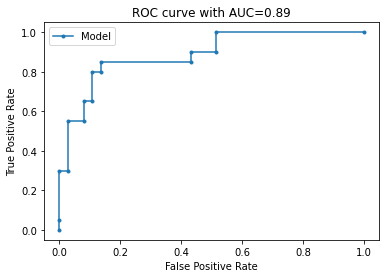

In [312]:
auc = roc_auc_score(test_y[:,0],  tf.nn.sigmoid(model.predict(test_x_full)).numpy().flatten(), multi_class='ovr')
fpr, tpr, _ = roc_curve(test_y[:,0],  tf.nn.sigmoid(model.predict(test_x_full)).numpy().flatten())
plt.plot(fpr, tpr, marker='.', label='Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title("ROC curve with AUC={:.2f}".format(auc))
# show the plot
plt.show()

In [360]:
test_x_full.shape

(57, 64, 64, 7)

Adding the interpretation layer

In [315]:
model.summary()

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 64, 64, 16)        1024      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_115 (Flatten)        (None, 8192)              0         
_________________________________________________________________
dense_203 (Dense)            (None, 128)             

In [318]:
import tensorflow.keras.backend as K


In [319]:
with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_100')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(train_x_full)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    pass
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

In [329]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap[0,:,:].reshape((8, 8))
plt.matshow(heatmap)
plt.show()

ValueError: cannot reshape array of size 1024 into shape (8,8)

(168, 32, 32)


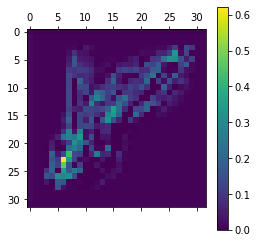

In [359]:
print(heatmap.shape)
plt.matshow(heatmap[-3,:,:])
plt.colorbar()
plt.show()

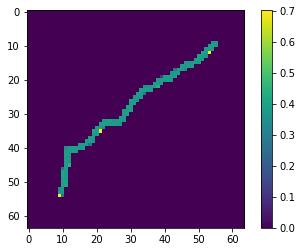

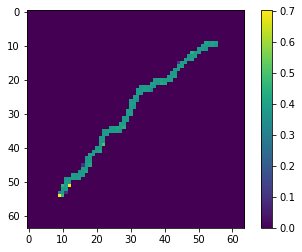

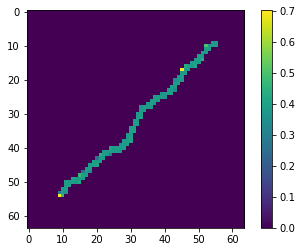

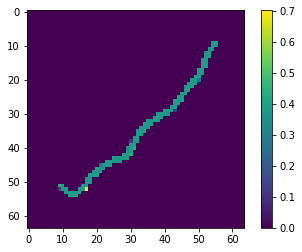

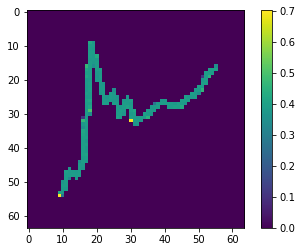

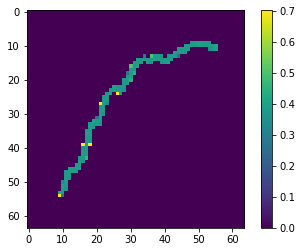

In [358]:
for i in range(7):
    plt.imshow(train_x[-3,:,:,i])
    plt.colorbar()
    plt.show()

In [313]:
tf.nn.sigmoid(model.predict(test_x_full))

<tf.Tensor: shape=(57, 1), dtype=float32, numpy=
array([[0.4352718 ],
       [0.519872  ],
       [0.51450306],
       [0.37294692],
       [0.76638985],
       [0.70277685],
       [0.38758925],
       [0.39561972],
       [0.42206806],
       [0.31904927],
       [0.6047324 ],
       [0.559223  ],
       [0.64102566],
       [0.42179403],
       [0.29688865],
       [0.30520087],
       [0.68405586],
       [0.6493367 ],
       [0.7625948 ],
       [0.61435103],
       [0.4669967 ],
       [0.5911098 ],
       [0.57286334],
       [0.6934284 ],
       [0.42195553],
       [0.61066985],
       [0.694498  ],
       [0.45549348],
       [0.39747876],
       [0.41351262],
       [0.41640082],
       [0.30991933],
       [0.25448942],
       [0.3792356 ],
       [0.5220991 ],
       [0.39433387],
       [0.37546647],
       [0.52920413],
       [0.5385273 ],
       [0.33372316],
       [0.30332726],
       [0.43748274],
       [0.66781765],
       [0.5958248 ],
       [0.70630854],
      

In [282]:
tn, fp, fn, tp = confusion_matrix(test_y[:,0], np.round(tf.nn.sigmoid(model.predict(test_x_two))).flatten()).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
positive_predictive_value = tp / (tp+fp)
print(f'Positive Predictive Value {positive_predictive_value}')
print(f'specificity {specificity}')
print(f'sensitivity {sensitivity}')
print(confusion_matrix(test_y[:,0], np.round(tf.nn.sigmoid(model.predict(test_x_two))).flatten()))

Positive Predictive Value 0.6071428571428571
specificity 0.7027027027027027
sensitivity 0.85
[[26 11]
 [ 3 17]]


In [283]:
tn, fp, fn, tp = confusion_matrix(train_y[:,0], np.round(tf.nn.sigmoid(model.predict(train_x_two))).flatten()).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
positive_predictive_value = tp / (tp+fp)
print(f'Positive Predictive Value {positive_predictive_value}')
print(f'specificity {specificity}')
print(f'sensitivity {sensitivity}')
print(confusion_matrix(train_y[:,0], np.round(tf.nn.sigmoid(model.predict(train_x_two))).flatten()))

Positive Predictive Value 0.7222222222222222
specificity 0.8275862068965517
sensitivity 1.0
[[96 20]
 [ 0 52]]


In [76]:
def gen_model(input_size, classes):
    input_layer = tf.keras.layers.Input(shape=input_size)
    
    #x = tf.keras.layers.Dense(64, activation="relu", name="dense_1")(input_layer)
    #x = tf.keras.layers.Conv2D(8, 7, activation='relu')(input_layer)
    #x = tf.keras.layers.Conv2D(16, 7, activation='relu')(x)
    #x = tf.keras.layers.Conv2D(32, 7, activation='relu')(x)
    #x = tf.keras.layers.Dense(1, activation="sigmoid", name="dense_2")(input_layer)
    
    #x = tf.keras.layers.MaxPool2D(2)(x)

    #x = tf.keras.layers.Conv2D(16, 7, activation='relu')(x)
    #x = tf.keras.layers.Conv2D(32, 7, activation='relu')(x)
    #x = tf.keras.layers.MaxPool2D(2)(x)

    #x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.Dense(256, activation='relu')(x)
    #output_layer = tf.keras.layers.Dense(classes, activation='softmax')(x)
    
    x = tf.keras.layers.Dense(64, activation="sigmoid", name="dense_2")(input_layer)
    x = tf.keras.layers.Flatten()(x)
    output_layer = tf.keras.layers.Dense(classes, activation='softmax')(x)
    full_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return full_model

In [100]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64,7)),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
model.fit(train_x, y_cardiac, batch_size=batch_size, epochs=15)

Epoch 1/15
11/11 [==============================] - 0s 12ms/step - loss: 4.8670 - acc: 0.6845
Epoch 2/15
11/11 [==============================] - 0s 12ms/step - loss: 4.8662 - acc: 0.6845
Epoch 3/15
11/11 [==============================] - 0s 12ms/step - loss: 4.8662 - acc: 0.6845
Epoch 4/15
11/11 [==============================] - 0s 12ms/step - loss: 4.8662 - acc: 0.6845
Epoch 5/15
11/11 [==============================] - 0s 13ms/step - loss: 4.8662 - acc: 0.6845
Epoch 6/15
11/11 [==============================] - 0s 14ms/step - loss: 4.8662 - acc: 0.6845
Epoch 7/15
11/11 [==============================] - 0s 13ms/step - loss: 4.8662 - acc: 0.6845
Epoch 8/15
11/11 [==============================] - 0s 12ms/step - loss: 4.8662 - acc: 0.6845
Epoch 9/15
11/11 [==============================] - 0s 12ms/step - loss: 4.8662 - acc: 0.6845
Epoch 10/15
11/11 [==============================] - 0s 13ms/step - loss: 4.8662 - acc: 0.6845
Epoch 11/15
11/11 [==============================] - 0s 14m

In [98]:
y_cardiac =data[['CardiacLim']].values[s1]
model = gen_model((64, 64, 7), 1)
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
batch_size = 16
model.fit(train_x, y_cardiac, batch_size=batch_size, epochs=15)

Epoch 1/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 2/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 3/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 4/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 5/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 6/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 7/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 8/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 9/15
11/11 [==============================] - 0s 14ms/step - loss: 10.4385 - acc: 0.3155
Epoch 10/15
11/11 [==============================] - 0s 15ms/step - loss: 10.4385 - acc: 0.3155
Epoch 11/15
11/11 [==============================

In [101]:
model.predict(test_x)

array([[-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663828],
       [-0.45663828],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0.45663822],
       [-0

## Multichannel model

In [68]:
def gen_model(input_size, classes):
    input_layer = tf.keras.layers.Input(shape=input_size)
    
    #x = tf.keras.layers.Dense(64, activation="relu", name="dense_1")(input_layer)
    #x = tf.keras.layers.Conv2D(8, 7, activation='relu')(input_layer)
    #x = tf.keras.layers.Conv2D(16, 7, activation='relu')(x)
    #x = tf.keras.layers.Conv2D(32, 7, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid", name="dense_2")(input_layer)
    
    #x = tf.keras.layers.MaxPool2D(2)(x)

    #x = tf.keras.layers.Conv2D(16, 7, activation='relu')(x)
    #x = tf.keras.layers.Conv2D(32, 7, activation='relu')(x)
    #x = tf.keras.layers.MaxPool2D(2)(x)

    #x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.Dense(256, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(classes, activation='softmax')(x)

    full_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return full_model

In [44]:
model = gen_model((64, 64, 7), 3)

In [45]:
train_y = data[['CardiacLim','PulmonaryLim','MuscleSkeletalLim']].values[s1]
test_y = data[['CardiacLim','PulmonaryLim','MuscleSkeletalLim']].values[s2]

In [109]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 7)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3)
])

In [113]:
train_x.shape

(168, 64, 64, 7)

In [115]:
#model = gen_model((64, 64, 7), 3)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
batch_size = 16
#model.fit(train_x, train_y, epochs=10)
model.fit(train_x, train_y, batch_size=batch_size, epochs=20)

Epoch 1/20
11/11 [==============================] - 0s 13ms/step - loss: 5.0849 - acc: 0.1607
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 5.0849 - acc: 0.1607
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 5.0849 - acc: 0.1607
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 5.0849 - acc: 0.1607
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 5.0849 - acc: 0.1607
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 5.0849 - acc: 0.1607
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 5.0849 - acc: 0.1607
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 5.0849 - acc: 0.1607
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 5.0849 - acc: 0.1607
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 5.0849 - acc: 0.1607
Epoch 11/20
11/11 [==============================] - 0s 13m

In [116]:
test_loss, test_acc = model.evaluate(test_x, test_y, batch_size=16)


4/4 [==============================] - 0s 3ms/step - loss: 5.3727 - acc: 0.1579


In [117]:
model.predict(test_x)

array([[-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3.5821655,  3.4439542,  2.927446 ],
       [-3

In [191]:
train_x.shape

(168, 64, 64, 7)

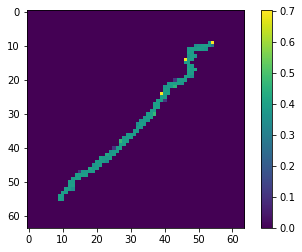

In [192]:
plt.imshow(train_x[0,:,:,0])
plt.colorbar()

In [147]:
test_x.shape

(57, 64, 64, 7)

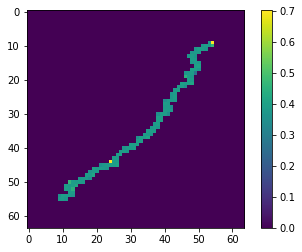

In [194]:
plt.imshow(test_x[1,:,:,2])
plt.colorbar()

In [71]:
train_array = []
height = 0
width = 0
for item in s1:
    result = load_img(data.iloc[item].HR, True)
    height = result[2]
    width = result[1]
    train_array.append(result[0])
train_x = np.array(train_array).reshape(len(s1), height,width,1)
train_x.shape

(168, 64, 64, 1)

In [72]:
test_array = []
height = 0
width = 0
for item in s2:
    result = load_img(data.iloc[item].HR, True)
    height = result[2]
    width = result[1]
    test_array.append(result[0])
test_x = np.array(test_array).reshape(len(s2), height,width,1)
test_x.shape

(57, 64, 64, 1)

In [56]:
test_array = []
for item in s2:
    width, height = image.size
    image = Image.open('./data/images/'+data.iloc[item].HR)
    image = ImageOps.grayscale(image)
    result = np.array(image).astype(np.float32) / 255.0
    test_array.append(result)
test_x = np.array(test_array).reshape(len(s2), height,width,1)
test_x.shape

(57, 288, 432, 1)

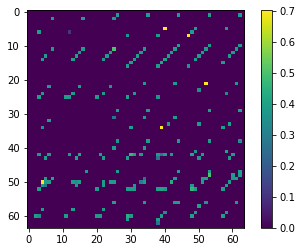

In [146]:
plt.imshow(train_x[0,:,:,0])
plt.colorbar()

In [51]:
train_y = data[['CardiacLim','PulmonaryLim','MuscleSkeletalLim']].values[s1]
test_y = data[['CardiacLim','PulmonaryLim','MuscleSkeletalLim']].values[s2]

## First neural network

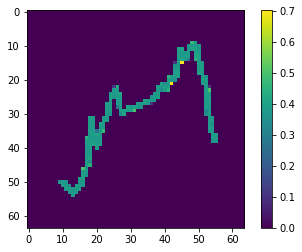

In [247]:
plt.imshow(test_x[21,:,:,0])
plt.colorbar()

In [257]:
import tensorflow as tf
def gen_model(input_size, classes):
    input_layer = tf.keras.layers.Input(shape=input_size)
    
    x = tf.keras.layers.Conv2D(8, 7, activation='relu')(input_layer)
    x = tf.keras.layers.Conv2D(16, 7)(x)
    x = tf.keras.layers.Conv2D(32, 7)(x)
    
    x = tf.keras.layers.MaxPool2D(2)(x)

    #x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    #x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    #x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    #x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128)(x)
    output_layer = tf.keras.layers.Dense(classes, activation='softmax')(x)

    full_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return full_model

In [258]:
model = gen_model((64, 64, 7), 3)

In [259]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])
batch_size = 5
model.fit(train_x, train_y, batch_size=batch_size, epochs=30)

Epoch 1/30
34/34 [==============================] - 1s 42ms/step - loss: 417084735488.0000 - acc: 0.4881
Epoch 2/30
34/34 [==============================] - 1s 42ms/step - loss: 183848373583872.0000 - acc: 0.5119
Epoch 3/30
34/34 [==============================] - 1s 40ms/step - loss: 279634247680000.0000 - acc: 0.4702
Epoch 4/30
34/34 [==============================] - 1s 40ms/step - loss: 228209564057600.0000 - acc: 0.5000
Epoch 5/30
34/34 [==============================] - 1s 40ms/step - loss: 220575914000384.0000 - acc: 0.5179
Epoch 6/30
34/34 [==============================] - 1s 41ms/step - loss: 219373641924608.0000 - acc: 0.5060
Epoch 7/30
34/34 [==============================] - 1s 40ms/step - loss: 220278319742976.0000 - acc: 0.4762
Epoch 8/30
34/34 [==============================] - 1s 41ms/step - loss: 258531697623040.0000 - acc: 0.4881
Epoch 9/30
34/34 [==============================] - 1s 42ms/step - loss: 320093275815936.0000 - acc: 0.4583
Epoch 10/30
34/34 [============

In [260]:
model.predict(test_x)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [96]:
test_loss, test_acc = model.evaluate(test_x, test_y, batch_size=16)


2/2 [==============================] - 0s 8ms/step - loss: 0.8470 - acc: 0.6667


In [225]:
def gen_model(image_size, num_layers, pooling = False, constant_growth=False, doubling=False):
    input_layer = tf.keras.layers.Input(image_size)
    num_filters = 8
    x=input_layer
    for i in range(num_layers):
        x = tf.keras.layers.Conv2D(num_filters, 3, activation='relu')(x)
        if constant_growth:
            num_filters += 4
        if doubling:
            num_filters = num_filters*2
        if pooling and i%2 ==1:
            x = tf.keras.layers.MaxPool2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    out = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=out)
    return model

In [226]:
image_size = (64, 64, 1)
num_layers = 3
model1 = gen_model(image_size=image_size, num_layers=num_layers,pooling=True,constant_growth=True,doubling=True)

# optional summary to visualize your model
model1.summary()
loss_fn_name = "categorical_crossentropy"
metrics = ['acc']
model1.compile(loss=loss_fn_name, metrics=metrics)

# training
num_epochs = 10
model1.fit(train_x, train_y, epochs=num_epochs, batch_size=64)
test_perf = model1.evaluate(test_x, test_y, batch_size=64)

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 62, 62, 8)         80        
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 60, 60, 24)        1752      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 24)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 56)        12152     
_________________________________________________________________
flatten_46 (Flatten)         (None, 43904)             0         
_________________________________________________________________
dense_71 (Dense)             (None, 3)               

ValueError: in user code:

    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\julio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer conv2d_42 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [None, 64, 64, 7]


In [ ]:
image_size = (28, 28, 1)
num_layers = 5
model1 = gen_model(image_size=image_size, num_layers=num_layers,pooling=True,constant_growth=True,doubling=True)

In [121]:
train_x.shape

(168, 64, 64, 7)

## Second attempt

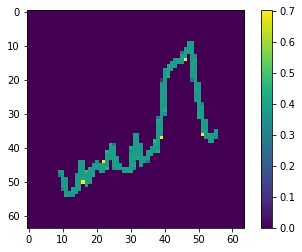

In [261]:
plt.imshow(train_x[0,:,:,0])
plt.colorbar()

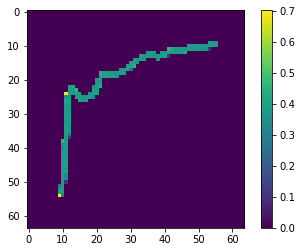

In [262]:
plt.imshow(train_x[50,:,:,0])
plt.colorbar()

In [53]:
test_y[:,0]

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [54]:
test_y_cardiac = 
test_y_cardiac

SyntaxError: invalid syntax (<ipython-input-54-a1645de11b17>, line 1)

In [77]:
model.predict(train_x_one)

array([[-2.14211792e-01],
       [-2.77381688e-01],
       [-3.19051474e-01],
       [-2.24153847e-01],
       [ 6.65821970e-01],
       [ 8.84722546e-03],
       [ 8.46334100e-01],
       [ 7.49683321e-01],
       [-3.32737863e-02],
       [ 6.10900521e-01],
       [-1.39087200e-01],
       [ 5.08094668e-01],
       [ 3.04931492e-01],
       [ 8.73527527e-01],
       [ 1.34980321e-01],
       [ 5.13973117e-01],
       [-3.29923451e-01],
       [ 1.85192525e-01],
       [-5.62868118e-02],
       [-1.06833704e-01],
       [ 5.91098189e-01],
       [ 7.07444787e-01],
       [-9.98790488e-02],
       [ 4.71083373e-01],
       [ 5.50630510e-01],
       [ 5.42894185e-01],
       [-1.68667912e-01],
       [ 2.48360857e-02],
       [-1.17570780e-01],
       [ 6.80215001e-01],
       [-6.44030496e-02],
       [-5.94843477e-02],
       [ 7.62583852e-01],
       [-4.22408208e-02],
       [ 9.25450772e-03],
       [ 3.63902897e-01],
       [-1.92264095e-02],
       [-6.08095378e-02],
       [-6.0

In [136]:
num_classes = 3
img_width = 64
img_height = img_width
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1., input_shape=(img_height, img_width, 7)),
  layers.Conv2D(16, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [137]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [139]:
epochs = 10
history = model.fit(
  train_x,
  validation_data=train_y,
  epochs=epochs
)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [127]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 7)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 16)        5504      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        25120     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)              

In [140]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])
batch_size = 16
model.fit(train_x, train_y, epochs=10)

Epoch 1/10
6/6 [==============================] - 1s 90ms/step - loss: 4.1746 - acc: 0.1310
Epoch 2/10
6/6 [==============================] - 0s 80ms/step - loss: 4.0295 - acc: 0.1607
Epoch 3/10
6/6 [==============================] - 0s 80ms/step - loss: 4.0295 - acc: 0.1607
Epoch 4/10
6/6 [==============================] - 0s 80ms/step - loss: 4.0295 - acc: 0.1607
Epoch 5/10
6/6 [==============================] - 0s 79ms/step - loss: 4.0295 - acc: 0.1607
Epoch 6/10
6/6 [==============================] - 0s 83ms/step - loss: 4.0295 - acc: 0.1607
Epoch 7/10
6/6 [==============================] - 0s 81ms/step - loss: 4.0295 - acc: 0.1607
Epoch 8/10
6/6 [==============================] - 0s 76ms/step - loss: 4.0295 - acc: 0.1607
Epoch 9/10
6/6 [==============================] - 0s 74ms/step - loss: 4.0295 - acc: 0.1607
Epoch 10/10
6/6 [==============================] - 0s 75ms/step - loss: 4.0295 - acc: 0.1607


In [ ]:
img = './data/images/'

In [29]:
image = Image.open('./data/images/'+'7_0_HR.png')
image = ImageOps.grayscale(image)
result = np.array(image).astype(np.float32) / 255.0

In [30]:
result.shape

(288, 432)

In [26]:
image.size

(432, 288)

In [21]:
y_train_data

array([[0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 1, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1,

In [4]:
# loading data, run once
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
x_data = train_images.reshape(60000, 28, 28, 1) / 255.0
y_data = np.eye(10)[train_labels]
train_x = x_data[0:50000]
train_y = y_data[0:50000]
val_x = x_data[50000:]
val_y = y_data[50000:]
test_x = test_images.reshape(10000, 28, 28, 1) / 255.0
test_y = np.eye(10)[test_labels]


4423680/4422102 [==============================] - 2s 0us/step


In [8]:
test_y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Learning section

In [80]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [81]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [82]:
mnist_images.shape

(60000, 28, 28)

In [84]:
for images,labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.01999706  0.02437657 -0.00249255  0.03455496  0.05811289 -0.08384725
  -0.00047812  0.01062006 -0.06784426  0.03455658]]


In [85]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [88]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        
        # Add asserts to check the shape of the output.
        tf.debugging.assert_equal(logits.shape, (32, 10))
        
        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [90]:
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print ('Epoch {} finished'.format(epoch))

In [91]:
train(4)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished


Text(0, 0.5, 'Loss [entropy]')

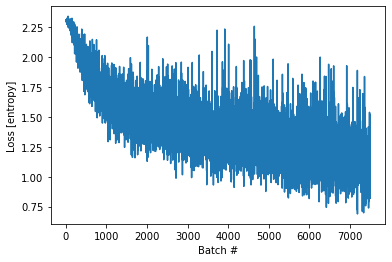

In [92]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [93]:
for images,labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.04110104 -7.0134144   0.728264   -0.610577    1.1948074  -0.75875795
   2.6819525  -1.4304737   1.5704012   1.0614107 ]]
